In [47]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, device=device, dtype=torch.float32),
    torch.tensor(X_test, device=device, dtype=torch.float32),
    torch.tensor(y_train, device=device, dtype=torch.long),
    torch.tensor(y_test, device=device, dtype=torch.long),
)

In [48]:
import torch.nn as nn
class IrisClassifier(nn.Module):
    def __init__(self):
        super(IrisClassifier, self).__init__()
        self.linear = nn.Linear(4, 3)

    def forward(self, x):
        x = self.linear(x)
        return x

In [49]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from collections import namedtuple
from torch.utils.data import DataLoader

ModelInfo = namedtuple("ModelInfo", ["state_dict", "matrix", "accuracy"])

def train_model(train_loader: DataLoader):
    model = IrisClassifier().to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    model.train()
    num_epochs = 200
    for _ in range(num_epochs):
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, labels = torch.max(y_pred, 1)
        accuracy = accuracy_score(y_test.cpu().numpy(), labels.cpu().numpy())
    W = model.linear.weight.data
    b = model.linear.bias.data
    b = b.view(-1, 1)
    Wb_matrix = torch.cat((W, b), dim=1)
    return ModelInfo(state_dict=model.state_dict(), matrix=Wb_matrix, accuracy=accuracy)

In [50]:
from torch.utils.data import TensorDataset, DataLoader

NUM_OF_MODELS = 500

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

real_models = []
for _ in range(NUM_OF_MODELS):
    model_info = train_model(train_loader)
    real_models.append(model_info)

In [51]:
scrambled_models = []
for _ in range(NUM_OF_MODELS):
    scramble_indices = torch.randperm(y_train.size(0), device=device)
    y_train_scrambled = y_train[scramble_indices]

    train_dataset_scrambled = TensorDataset(X_train, y_train_scrambled)
    train_loader_scrambled = DataLoader(
        train_dataset_scrambled, batch_size=16, shuffle=True
    )
    model_info = train_model(train_loader_scrambled)
    scrambled_models.append(model_info)

In [60]:
import pickle

# scrambled = tuple(scramble_indices)
real_matrix_list = [real.matrix for real in real_models]
scrambled_matrix_list = [s.matrix for s in scrambled_models]

# Save the list to a file
with open('scrambled_matrix_list.pickle', 'wb') as f:
    pickle.dump(scrambled_matrix_list, f)

with open('real_matrix_list.pickle', 'wb') as f:
    pickle.dump(real_matrix_list, f)


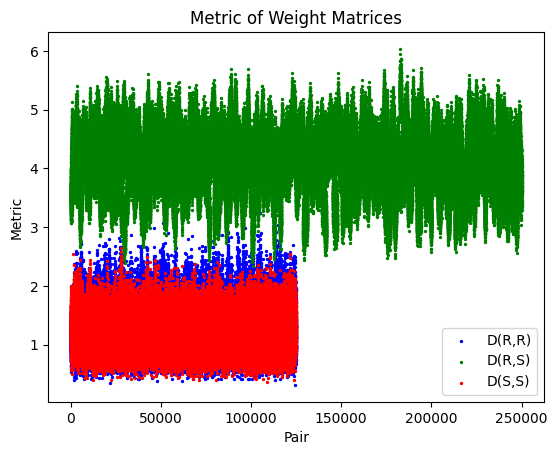

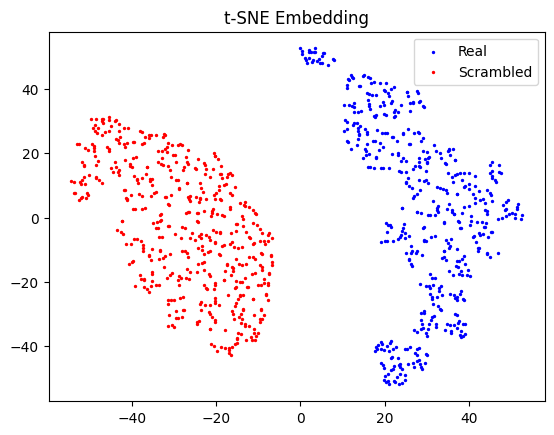

Diag(R): 0.9637
Diag(S): 0.2689
